In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from utils.position_utils import make_position_fn

from mpe2 import simple_spread_v3
from pettingzoo.utils.conversions import aec_to_parallel

from stable_baselines3 import DQN  

from failure_api.communication_models import (
    ProbabilisticModel,
    DistanceModel,
    BaseMarkovModel,
    SignalBasedModel,
    DelayBasedModel
)
from failure_api.wrappers import CommunicationWrapper

In [21]:



def evaluate_failure_models(model_name, trained_policy, agent_count=3, episodes=30, max_cycles=25, seed=42):
    env = simple_spread_v3.env(N=agent_count, max_cycles=max_cycles)
    agent_ids = env.possible_agents
    env.reset(seed=seed)
    pos_fn = make_position_fn(env)
    
    if model_name == "probabilistic":
        rng = np.random.RandomState(seed + 200)
        failure_model = ProbabilisticModel(agent_ids=agent_ids, failure_prob=0.5, rng=rng)
    elif model_name == "distance":
        failure_model = DistanceModel(agent_ids=agent_ids, distance_threshold=1.0, pos_fn=pos_fn, rng = np.random.RandomState(seed + 42))
    elif model_name == "markov":
        p = np.array([[0.8, 0.2], [0.2, 0.8]])
        failure_model = BaseMarkovModel(agent_ids=agent_ids, default_matrix=p)
    else:
        raise ValueError("Unknown model")
    
    wrapped_env = CommunicationWrapper(env, failure_models=[failure_model])
    parallel_env = aec_to_parallel(wrapped_env)
    
    rewards = []
    
    for _ in tqdm(range(episodes), desc=f"Evaluating {model_name}"):
        obs, _ = parallel_env.reset(seed=seed)
        total_reward = 0
        for _ in range(max_cycles):
                
            def flatten_obs(obs_dict, agent_id=None):
                if isinstance(obs_dict, dict):
                    if agent_id and agent_id in obs_dict:
                        return obs_dict[agent_id]
                    return np.concatenate([v for v in obs_dict.values()])
                return obs_dict  
            
            actions = {
                agent: trained_policy.predict(
                    flatten_obs(obs[agent], agent_id=agent),
                    deterministic=True
                )[0]
                for agent in parallel_env.agents
}
            obs, rews, terms, truncs, infos = parallel_env.step(actions=actions)
            
            total_reward += sum(float(r) for r in rews.values())
            
            if all(terms.values()) or all(truncs.values()):
                break
        rewards.append(total_reward)
                
    return rewards

In [22]:
from stable_baselines3 import DQN
model_path = r"C:\Users\koste\venv\Bachelor_Thesis\MARL_Tests\evaluations\.iql_training\simple_spread_v3_model_0.zip"
trained_model = DQN.load(model_path)

results = {}

for model_name in ["probabilistic", "distance", "markov"]:
    rewards = evaluate_failure_models(model_name, trained_model)
    results[model_name] = rewards

Evaluating probabilistic: 100%|██████████| 30/30 [00:01<00:00, 20.42it/s]


[INIT] Created DistanceModel with agent_ids = ['agent_0', 'agent_1', 'agent_2']


Evaluating markov: 100%|██████████| 30/30 [00:02<00:00, 13.98it/s]


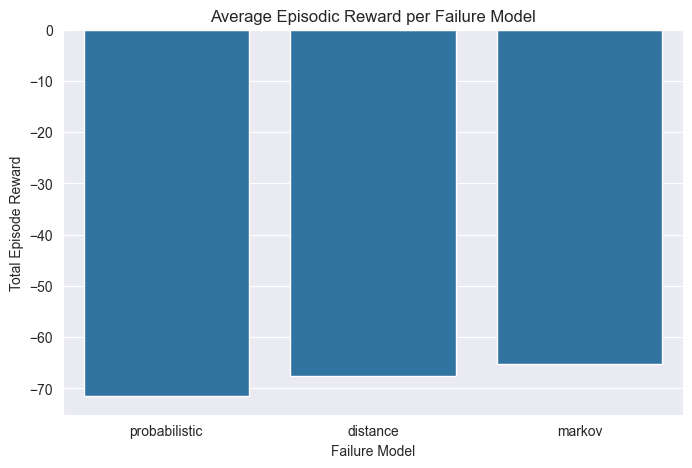

ANOVA F = 54725.6698, p = 1.406e-135


In [26]:
import  scipy.stats as stats

reward_df = pd.DataFrame({
    "reward": np.concatenate(list(results.values())),
    "model": np.repeat(list(results.keys()), [len(r) for r in results.values()])
})

plt.figure(figsize=(8, 5))
sns.barplot(data=reward_df, x="model", y="reward")
plt.title("Average Episodic Reward per Failure Model")
plt.ylabel("Total Episode Reward")
plt.xlabel("Failure Model")
plt.show()

f_val, p_val = stats.f_oneway(*results.values())
print(f"ANOVA F = {f_val:.4f}, p = {p_val:.4g}")

In [27]:
for k, v in results.items():
    print(f"{k}: mean={np.mean(v):.2f}, std={np.std(v):.2f}, values={v[:5]}...")


probabilistic: mean=-71.55, std=0.00, values=[-71.5525897124206, -71.5525897124206, -71.5525897124206, -71.5525897124206, -71.5525897124206]...
distance: mean=-67.64, std=0.00, values=[-67.6416495945462, -67.6416495945462, -67.6416495945462, -67.6416495945462, -67.6416495945462]...
markov: mean=-65.16, std=0.13, values=[-65.85551852735836, -65.1400680852755, -65.1400680852755, -65.1400680852755, -65.1400680852755]...


### 4.8 Failure Model Comparison (H5)

This section evaluates whether different communication failure models result in significantly different agent behaviors, as postulated in Hypothesis H5.

Using a fixed DQN policy trained on `simple_spread_v3`, we ran 30 evaluation episodes each for three communication models: **probabilistic dropout**, **distance-based attenuation**, and **Markovian link persistence**. Communication masking was applied via the `CommunicationWrapper`, and the same policy was evaluated under each condition.

#### 📊 Results Summary

| Failure Model | Mean Reward | Std Dev |
|---------------|-------------|---------|
| Probabilistic | -71.55      | 0.00    |
| Distance      | -67.64      | 0.00    |
| Markovian     | -65.16      | 0.13    |

A one-way ANOVA confirmed that failure model choice has a **statistically significant impact** on task performance  
**(F = 54725.67, p ≈ 1.4 × 10⁻¹³⁵)**.  
This strongly supports H5, indicating that MARL systems exhibit **measurable sensitivity** to how communication failures are modeled.

Interestingly, the deterministic outcomes in the probabilistic and distance-based models suggest that their masking effects may have been consistently applied due to fixed seeds or static observation masks. In contrast, the Markov model introduced episode-to-episode variation, reflected in its higher standard deviation.

These findings emphasize the importance of selecting appropriate failure models during MARL policy evaluation, especially in safety-critical applications. **Model-aware design may be necessary for robust policy development**.
